# <center> Modelos AutoRegressivo - AR </center>

### Importações

In [48]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_absolute_error
import seaborn as sns

### Lendo a base de dados

In [49]:
df = pd.read_excel('serie_aula_ar.xlsx')
display(df)

,serie
0,0.000000
1,0.997345
2,0.981120
3,-0.819510
4,-1.152258
...,...
195,-3.189811
196,-2.502161
197,-1.862364
198,-1.644916


### Plotando a base

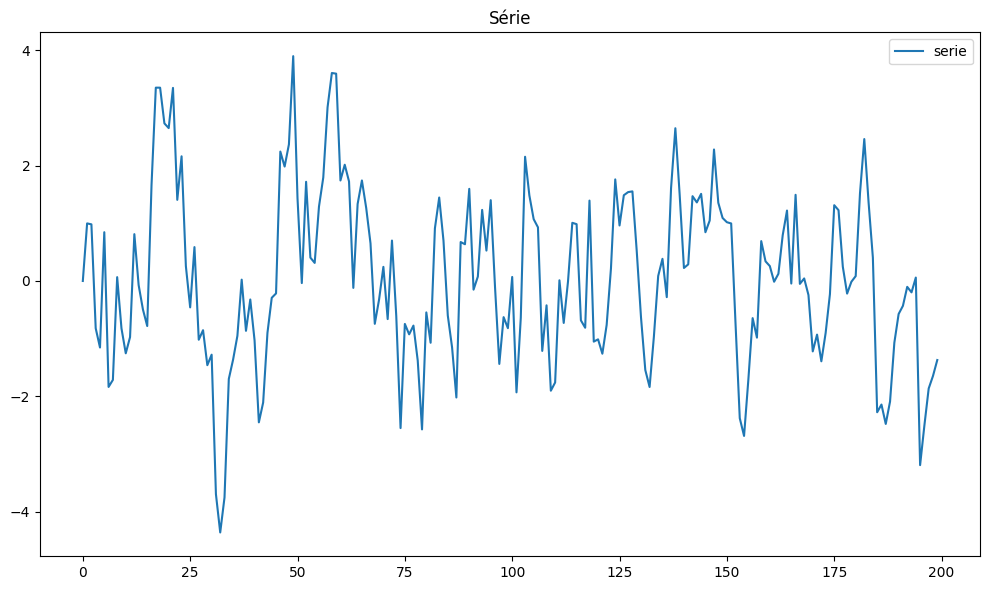

In [50]:
df.plot(subplots=True, figsize=(10, 6), title=["Série"])
plt.tight_layout()
plt.show()

### Implementando as funções de autocovariancia e autocorrelação
- Autocorrelação é uma autocovariancia padronizada.

In [51]:
# funcao calcular a autocovariância ( populacional )
def autocovariance(series, lag):
    n = len(series)
    mean = np.mean(series)
    return np.sum((series[lag:] - mean) * (series[:n - lag] - mean)) / n

# funcao para calcular a autocorrelação
def autocorrelation(series, lag):
    return autocovariance(series, lag) / autocovariance(series, 0)

### Calculando a autocovariância e autocorrelação para ambas as bases.

In [52]:
serie_original = df['serie']

max_lag = 25
lags = range(0, max_lag + 1)

auto_cov_est = [autocovariance(serie_original, lag) for lag in lags]
auto_cov_nao = [autocovariance(serie_original, lag) for lag in lags]

### Separação Treino e Teste

In [53]:
# treino e teste - multi-step head

horizonte = 4
train = serie_original[:-horizonte]
test = serie_original[-horizonte:]

### Plotando o gráfico de ACF
Começando a confirmação para ver se a série é ou não estacionária.

<Figure size 1000x400 with 0 Axes>

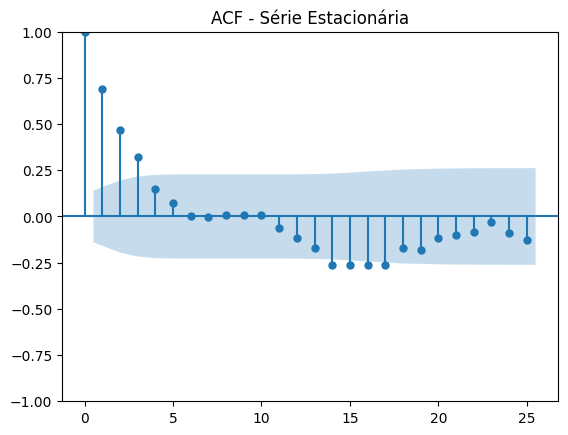

In [54]:
# plot das autocorrelações com statsmodels (ACF)
plt.figure(figsize=(10, 4))
plot_acf(train, lags=max_lag, title="ACF - Série Estacionária")
plt.show()

### Plotando o gráfico de PACF
Começando a confirmação para ver se a série é ou não estacionária parcialmente.

<Figure size 1000x400 with 0 Axes>

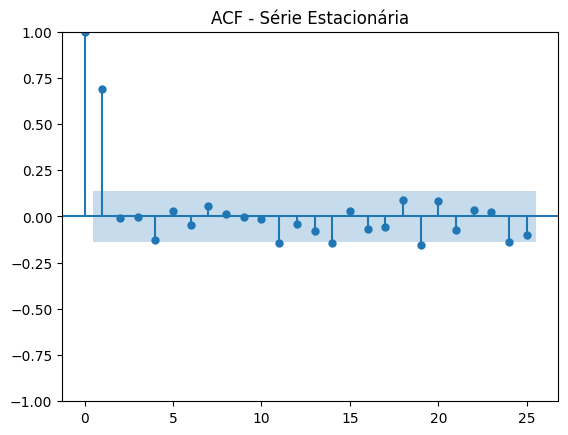

In [55]:
# plot das autocorrelações com statsmodels (ACF)
plt.figure(figsize=(10, 4))
plot_pacf(train, lags=max_lag, title="ACF - Série Estacionária")
plt.show()

### Testes de Estacionaridade (Teste de Hipótese)
Confirmar se a série é ou não estacionária

ADF: Testa se a série não é estacionária.
H0: Não-Estacionaria
H1: Estacionaria
p ≤ 0,05
<hr>
KPSS
H0: Estacionaria
H1: Não-Estacionaria
p > 0,05

#### ADF

In [56]:
# realizando o teste ADF e coletando resultados
resultado_adf = adfuller(train)

# Apresentando resultados
print("Estatística ADF: ", resultado_adf[0])
print("p-valor", resultado_adf[1])
print("Valores críticos: ")

for chave, valor in resultado_adf[4].items():
    print(f"{chave}: {valor}")

# Conclusão
if resultado_adf[1] <= 0.05:
    print("Rejeita H0")
else:
    print("Não rejeita H0")

Estatística ADF:  -5.614910759492596
p-valor 1.1804174607954243e-06
Valores críticos: 
1%: -3.464337030867007
5%: -2.876478799035722
10%: -2.574733103221565
Rejeita H0


#### KSPP

In [57]:
resultado_kpss = kpss(train, regression="c")

# Apresentando resultados
print("Estatística KPSS: ", resultado_kpss[0])
print("p-valor", resultado_kpss[1])
print("Valores críticos: ")

for chave, valor in resultado_kpss[3].items():
    print(f"{chave}: {valor}")

# Conclusão
if resultado_kpss[1] > 0.05:
    print("Não rejeita H0")
else:
    print("Rejeita H0")

Estatística KPSS:  0.05952321660308823
p-valor 0.1
Valores críticos: 
10%: 0.347
5%: 0.463
2.5%: 0.574
1%: 0.739
Não rejeita H0


### BIC - Critério de seleção de modelos que equilibra ajuste e simplicidade.
Quanto menor o valor do BIC melhor, pois indica um ajuste (grude) na base muito bom

In [58]:
p_max = 20 # testando alguns lags (nao coloque muito alto)

# inicializando variaveis
melhor_p = None
melhor_modelo = None
menor_bic = np.inf # infinito pois qualquer bic inicial ganha

for p in range(1, p_max+1):
    m = AutoReg(train, lags=p, old_names=False).fit()
    if m.bic < menor_bic:
        # guardando melhor modelo e suasss infos
        melhor_p = p
        melhor_modelo = m
        menor_bic = m.bic
        print(menor_bic)

print("Melhor p: ", melhor_p)
print("Menor BIC: ", menor_bic)

592.7435744605792
Melhor p:  1
Menor BIC:  592.7435744605792


### Aplicando o Modelo AutoRegressivo - AR

In [59]:
# previsao recursiva multi-step (t+1 ... t+horizonte)
previsoes = melhor_modelo.predict(start=len(train), end=len(train)+horizonte-1)

# avaliacao por horizonte e meddia
abs_err = np.abs(previsoes - test)
df_eval = pd.DataFrame({
    'horizonte': np.arange(1, horizonte+1),
    'previsao': previsoes,
    'real': test,
    'abs_err': abs_err
})
print(df_eval)
print("MAE médio: ", abs_err.mean())

     horizonte  previsao      real   abs_err
196          1 -2.241075 -2.502161  0.261086
197          2 -1.570482 -1.862364  0.291882
198          3 -1.096489 -1.644916  0.548428
199          4 -0.761457 -1.369388  0.607931
MAE médio:  0.42733164266300905


### Verificando ajuste do modelo

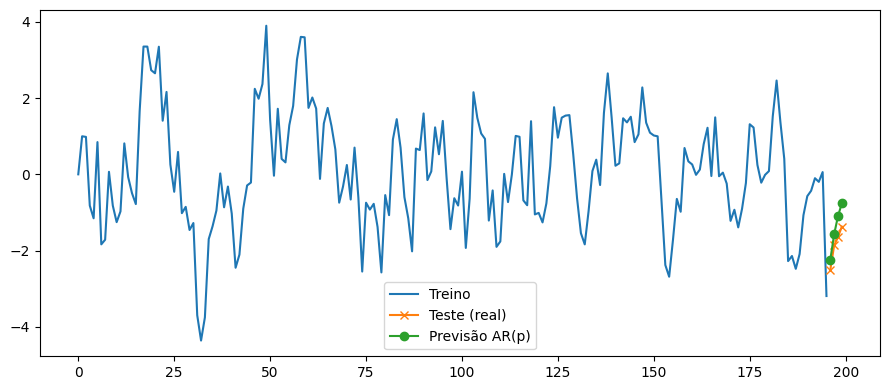

In [60]:
# plotando a curva originall + previsoa + valores reais esperados
plt.figure(figsize=(9, 4))
plt.plot(range(len(train)), train, label='Treino')
plt.plot(range(len(train), len(train)+horizonte), test, marker = 'x', label='Teste (real)')
plt.plot(range(len(train), len(train)+horizonte), previsoes, marker = 'o', label='Previsão AR(p)')
plt.legend()
plt.tight_layout()
plt.show()

### Autocorrelação nos resíduos - Ljung-Box
Verificar se os resíduos são esperados ou não, para isso vamos utilizar o Ljung-Box, que é um teste "portmanteau" (tudo em um) que verifica se os resíduos ainda têm autocorrelação conjunta até um lag h. Ele checa conjuntamente se todas as autocorrelações até o lag h são zero (resíduos = ruído), em vez de olhar lag por lag separadamente.

Ljung Box (lag=20):
      lb_stat  lb_pvalue
1    0.117597   0.731655
20  31.980426   0.043507


<Figure size 800x400 with 0 Axes>

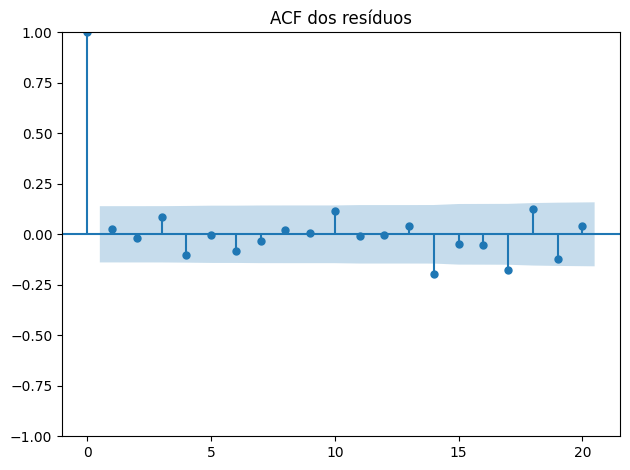

In [62]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# capturando residuos
res = modelo_final.resid

# Ljung-Box em lag 20 (pod ajustar)
lb = acorr_ljungbox(res, lags=[1, 20])
print("Ljung Box (lag=20):")
print(lb)

# ACF dos residuos - esperamos valores nas bandas
plt.figure(figsize=(8, 4))
plot_acf(res, lags=20)
plt.title("ACF dos resíduos")
plt.tight_layout()
plt.show()
